# 4 - Convolutional Sentiment Analysis

In the previous notebooks, we managed to achieve a test accuracy of ~85% using RNNs and an implementation of the [Bag of Tricks for Efficient Text Classification](https://arxiv.org/abs/1607.01759) model. In this notebook, we will be using a *convolutional neural network* (CNN) to conduct sentiment analysis, implementing the model from [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882).

**Note**: This tutorial is not aiming to give a comprehensive introduction and explanation of CNNs. For a better and more in-depth explanation check out [here](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) and [here](https://cs231n.github.io/convolutional-networks/).

Traditionally, CNNs are used to analyse images and are made up of one or more *convolutional* layers, followed by one or more linear layers. The convolutional layers use filters (also called *kernels* or *receptive fields*) which scan across an image and produce a processed version of the image. This processed version of the image can be fed into another convolutional layer or a linear layer. Each filter has a shape, e.g. a 3x3 filter covers a 3 pixel wide and 3 pixel high area of the image, and each element of the filter has a weight associated with it, the 3x3 filter would have 9 weights. In traditional image processing these weights were specified by hand by engineers, however the main advantage of the convolutional layers in neural networks is that these weights are learned via backpropagation.

The intuitive idea behind learning the weights is that your convolutional layers act like *feature extractors*, extracting parts of the image that are most important for your CNN's goal, e.g. if using a CNN to detect faces in an image, the CNN may be looking for features such as the existance of a nose, mouth or a pair of eyes in the image.

So why use CNNs on text? In the same way that a 3x3 filter can look over a patch of an image, a 1x2 filter can look over a 2 sequential words in a piece of text, i.e. a bi-gram. In the previous tutorial we looked at the FastText model which used bi-grams by explicitly adding them to the end of a text, in this CNN model we will instead use multiple filters of different sizes which will look at the bi-grams (a 1x2 filter), tri-grams (a 1x3 filter) and/or n-grams (a 1x$n$ filter) within the text.

The intuition here is that the appearance of certain bi-grams, tri-grams and n-grams within the review will be a good indication of the final sentiment.

## Preparing Data

As in the previous notebooks, we'll prepare the data.

Unlike the previous notebook with the FastText model, we no longer explicitly need to create the bi-grams and append them to the end of the sentence.

As convolutional layers expect the batch dimension to be first we can tell TorchText to return the data already permuted using the `batch_first = True` argument on the field.

In [ ]:
!pip install torchtext==0.6 torch==1.13


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 887.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 55.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.1+cu118
    Uninstalling torch-2.0.1+cu118:
      Successfully uninstalled torch-2.0.1+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are instal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import RandomOverSampler
import random

df1 = pd.read_csv('/content/drive/MyDrive/Tower_Sentiment.csv', nrows=10000)
df2 = pd.read_csv('/content/drive/MyDrive/Tuatahi_Sentiment_CSV.csv', nrows=10000)
df3 = pd.read_csv('/content/drive/MyDrive/Laybuy_Sentiment.csv', nrows=10000)
df4 = pd.read_csv('/content/drive/MyDrive/T7_Sentiment_CSV.csv', encoding='latin1', nrows=10000)
df5 = pd.read_csv('/content/drive/MyDrive/NZPost_Sentiment.csv', nrows=10000)

def dropcolumns(df):
    columns_to_keep = ['Text', 'ID', 'Sentiment', 'FullSentiment', 'Source']  # Replace with the columns you want to keep

    # Drop all columns except the ones specified in columns_to_keep
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
    df.drop(columns=columns_to_drop, inplace=True)
    df = df[~df["Source"].str.contains("bot")]
    df = df.drop(columns=["Source"])
    return df

# Dropping columns that do not need to be read

# Truncate the DataFrame to contain only the first 3007 rows



In [ ]:
df1 = dropcolumns(df1)
df2 = dropcolumns(df2)
df3 = dropcolumns(df3)
df4 = dropcolumns(df4)
df5 = dropcolumns(df5)

In [102]:
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        word = random.choice(words)
        text = text.replace(word, word + ' ' + random.choice(words))
    return text

In [103]:


def cleandata(data):
  #Current amount of rows in dataset
  print(len(data))
  #dropping rows after 1500 because thats where we annotated to
  #df.drop(df.index[1500:], inplace=True)
  print(len(data))
  new = data['Text'].fillna('')
  grouped_df = data.groupby('ID').agg({'Text': lambda x: '. '.join(x.astype(str)), 'FullSentiment': 'first'}).reset_index()

  data.drop(data.columns[[1,3]], axis=1, inplace=True)
  #Dropping all NaN data points
  df_filled = data.dropna()
  #df_filled = df.fillna(" ")
  old_word = 'Neural'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)

  old_word = 'Positve'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)

  old_word = 'positive'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)

  old_word = 'Positive'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)

  old_word = 'Postitive'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)

  old_word = 'Neutral'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)

  old_word = 'Negative'
  new_word = 'neg'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)


  old_word = 'Negatve'
  new_word = 'neg'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)

  old_word = 'Neutal'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)


  old_word = 'Neutural'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  df_filled["Sentiment"] = df_filled["Sentiment"].replace(old_word, new_word)



  X = df_filled["Text"]
  y = df_filled["Sentiment"]

  # Convert 'X' to a NumPy array and reshape it to 2D
  X = np.array(X).reshape(-1, 1)

  # Initialize the RandomOverSampler with 'auto' sampling strategy
  oversampler = RandomOverSampler(sampling_strategy='auto')

  # Fit and transform the data to perform oversampling
  X_resampled, y_resampled = oversampler.fit_resample(X, y)

  # Create a new DataFrame with the resampled values
  df_filled = pd.DataFrame({'Text': X_resampled.ravel(), 'Sentiment': y_resampled})


  # You can apply random insertion to all rows in the 'Text' column
  df_filled['Text'] = df_filled['Text'].apply(lambda x: random_insertion(x, n=1))

  df_filled = df_filled.rename(columns={'Text': 'text', 'Sentiment': 'label'})
  # Save the modified DataFrame back to the CSV file
  df_filled.to_csv('/content/drive/MyDrive/Tower_Sentiment_New.csv', index=False)


  print(len(df_filled))
  df_filled.head()

  data =  df_filled
  grouped_data = grouped_df
  return data, grouped_data

In [105]:
df1.head()

,Text,Sentiment
0,I,Neutral
4,Yes,Neutral
8,I have a pending claim and the company fixing ...,Neutral
13,Hi there,Positive
17,I hv a question do ur cover for traveller if t...,Neutral


In [ ]:
data1, grouped_data1 = cleandata(df1)
data2, grouped_data2 = cleandata(df2)
data3, grouped_data3 = cleandata(df3)
data4, grouped_data4 = cleandata(df4)
#data5, grouped_data5 = cleandata(df5)

In [ ]:
data1.head()

,text,label
0,I,neu
1,Yes,neu
2,I have a pending claim and the company fixing ...,neu
3,Hi there,pos
4,I hv a question do ur cover for traveller if t...,neu


In [ ]:
grouped_data1.head()

,ID,Text,FullSentiment
0,00036309-c615-45b0-bd95-d4669b72e66b,I. Yes,Neutral
1,000715a4-1d49-4a54-8ee8-140808202926,I have a pending claim and the company fixing ...,Neutral
2,000c670b-4513-49d4-bf3a-daa371d4ef52,Hi there. I hv a question do ur cover for trav...,Positive
3,000d5541-0607-463a-b05c-aeb888a69233,Hi I actually wanted to cancel my policy,Positive
4,0016ac21-a8ae-476d-aa75-8c4b62ce175a,"Hi Charlie bot, im trying to add my airpoints ...",Positive


In [ ]:
def cleangrouped_data(grouped_data):
  grouped_data.drop(grouped_data.columns[[0]], axis=1, inplace=True)
  grouped_data = grouped_data.dropna()
  grouped_data.head()

  old_word = 'Neural'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)

  old_word = 'Positve'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)
  old_word = 'positive'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)

  old_word = 'Positive'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)

  old_word = 'Postitive'
  new_word = 'pos'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)

  old_word = 'Neutral'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)

  old_word = 'Negative'
  new_word = 'neg'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)


  old_word = 'Negatve'
  new_word = 'neg'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)

  old_word = 'Neutal'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)


  old_word = 'Neutural'
  new_word = 'neu'
  # Find rows containing the target word and replace it with the new word
  grouped_data['FullSentiment'] = grouped_data['FullSentiment'].replace(old_word, new_word)

  grouped_data = grouped_data.rename(columns={'Text': 'text', 'FullSentiment': 'label'})
  return grouped_data

In [ ]:
grouped_data1 = cleangrouped_data(grouped_data1)
grouped_data2 = cleangrouped_data(grouped_data2)
grouped_data3 = cleangrouped_data(grouped_data3)
grouped_data4 = cleangrouped_data(grouped_data4)


In [ ]:
grouped_data.head()

NameError: ignored

In [ ]:
# from imblearn.over_sampling import RandomOverSampler
# import numpy as np

# #Current amount of rows in dataset
# print(len(df))
# #dropping rows after 1500 because thats where we annotated to
# #df.drop(df.index[1500:], inplace=True)
# print(len(df))
# new = df['Text'].fillna('')
# grouped_df = df.groupby('ID').agg({'Text': '. '.join, 'FullSentiment': 'first'}).reset_index()
# df.drop(df.columns[[1,3]], axis=1, inplace=True)
# #Dropping all NaN data points
# df_filled = df.dropna()
# #df_filled = df.fillna(" ")
# old_word = 'Neural'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)

# old_word = 'Positve'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)

# old_word = 'positive'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)

# old_word = 'Positive'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)

# old_word = 'Postitive'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)

# old_word = 'Neutral'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)

# old_word = 'Negative'
# new_word = 'neg'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)


# old_word = 'Negatve'
# new_word = 'neg'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)

# old_word = 'Neutal'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)


# old_word = 'Neutural'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# df_filled['Sentiment'] = df_filled['Sentiment'].replace(old_word, new_word)



# X = df_filled['Text']
# y = df_filled['Sentiment']

# # Convert 'X' to a NumPy array and reshape it to 2D
# X = np.array(X).reshape(-1, 1)

# # Initialize the RandomOverSampler with 'auto' sampling strategy
# oversampler = RandomOverSampler(sampling_strategy='auto')

# # Fit and transform the data to perform oversampling
# X_resampled, y_resampled = oversampler.fit_resample(X, y)

# # Create a new DataFrame with the resampled values
# df_filled = pd.DataFrame({'Text': X_resampled.ravel(), 'Sentiment': y_resampled})


# # Save the modified DataFrame back to the CSV file
# df_filled.to_csv('/content/drive/MyDrive/Tower_Sentiment_New.csv', index=False)


# print(len(df_filled))
# df_filled.head()

In [ ]:
# result = df_filled['Sentiment'].str.contains("na")
# filtered_df = df_filled[result]

# print(filtered_df)

Empty DataFrame
Columns: [Text, Sentiment]
Index: []


In [ ]:
# grouped_df = grouped_df.dropna()
# grouped_df.head()

# old_word = 'Neural'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)

# old_word = 'Positve'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)

# old_word = 'positive'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)

# old_word = 'Positive'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)

# old_word = 'Postitive'
# new_word = 'pos'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)

# old_word = 'Neutral'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)

# old_word = 'Negative'
# new_word = 'neg'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)


# old_word = 'Negatve'
# new_word = 'neg'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)

# old_word = 'Neutal'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)


# old_word = 'Neutural'
# new_word = 'neu'
# # Find rows containing the target word and replace it with the new word
# grouped_df['FullSentiment'] = grouped_df['FullSentiment'].replace(old_word, new_word)


In [ ]:
# import random
# # Define the random_insertion function
# def random_insertion(text, n=1):
#     words = text.split()
#     for _ in range(n):
#         word = random.choice(words)
#         text = text.replace(word, word + ' ' + random.choice(words))
#     return text

# # Assuming you have a DataFrame 'df_filled' with a 'Text' column
# # You can apply random insertion to all rows in the 'Text' column
# df_filled['Text'] = df_filled['Text'].apply(lambda x: random_insertion(x, n=1))

# # Save the modified DataFrame back to the CSV file
# df_filled.to_csv('/content/drive/MyDrive/Tower_Sentiment_New.csv', index=False)

# print(len(df_filled))

1926


In [ ]:
texts = data1['text']
sentiments = data1['label']

data = []

# Iterate through each row in the dataset
for text, sentiment in zip(texts, sentiments):
    data.append((text, sentiment))

print(data)

[('I', 'neu'), ('Yes', 'neu'), ('I have a pending claim and the company fixing my car has chosen a date and has said my excess is $1000 according to Tower. My current policy states my excess is $500. \nMy claim number is Claim numberC90154716 Hi, Neetu is looking after my claim\n\n______', 'neu'), ('Hi there', 'pos'), ('I hv a question do ur cover for traveller if they caught Covid in overseas', 'neu'), ('No', 'neu'), ('Help with my quote', 'neu'), ('Hi I actually wanted to cancel my policy', 'pos'), ('Hi Charlie bot, im trying to add my airpoints details to my account but it wont save, details are as per my card', 'pos'), ('i have an account', 'neu'), ('airpoints', 'neu'), ('Yes', 'pos'), ('Emily Robertson', 'neu'), ('04.04.82', 'neu'), ('emilybroad04@gmail.com', 'neu'), ('Airpoints', 'neu'), ('Thanks Jackie', 'pos'), ('Thanks Jackie, have just added a screenshot', 'pos'), ("My insurance payment was scheduled for yesterday but it didn't come out due to the public holiday, when will th

In [ ]:
def concatinateDatasets(data1, data2):
  combined_data = pd.concat([data1, data2], axis=0, ignore_index=True)

  return combined_data

In [ ]:
def writeCsv(data):
  new_data = data.to_csv('/content/drive/MyDrive/new_data.csv', index=False)
  return new_data

In [122]:
combined1 = concatinateDatasets(data1, grouped_data1)
combined2 = concatinateDatasets(data2, grouped_data2)
combined3 = concatinateDatasets(data3, grouped_data3)
combined4 = concatinateDatasets(data4, grouped_data4)

combined1 = concatinateDatasets(combined1, combined2)
combined2 = concatinateDatasets(combined3, combined4)

combined_data = concatinateDatasets(combined1, combined2)

In [ ]:
len(combined_data)

4846

In [123]:
writeCsv(combined_data)

In [ ]:
das1 = concatinateDatasets(df1, df2)
das2 = concatinateDatasets(df3, df4)
das3 = concatinateDatasets(df5, das1)

das = concatinateDatasets(das2, das3)

das.head()

,Text,ID,Sentiment,FullSentiment
0,no,0002c8c4-6044-40ed-8224-42d518e1c30a,Neu,NaN
1,I can’t make a payment,0002c8c4-6044-40ed-8224-42d518e1c30a,Neu,NaN
2,Its not letting me place order,0002c8c4-6044-40ed-8224-42d518e1c30a,Neu,NaN
3,Trouble placing order,0002c8c4-6044-40ed-8224-42d518e1c30a,Neu,NaN
4,Help,0002c8c4-6044-40ed-8224-42d518e1c30a,Neu,NaN


In [160]:
texts = das['Text']

data = []

# Iterate through each row in the dataset
for text in zip(texts):
    data.append((text))

print(data)
print(len(data))

[('no',), ('I can’t make a payment ',), ('Its not letting me place order ',), ('Trouble placing order ',), ('Help',), ('Speak to an advisor',), ('Speak to advisor',), ('Speak to an advisor',), ('no',), ('Can’t place order ',), ('speak to advisor ',), ('Speak to an advisor',), ('Why is boohoo not on here anymore ',), ('no',), ('Need hwlp',), ('A shop',), ('Speak to someone',), ('Speak to an advisor',), ('Can not find amazon ',), ('Can not find Amazon shop ',), ('There is no amazon shop anymore ',), ('amazon ',), ('i can not find amazon shop ',), ('no',), ('i would like chat with live person ',), ('Speak to an advisor',), ('Can not find amazon on laybuy',), ('Hi my account is saying i have late payments but it shows wen look that they is nothing oay as orders were returned',), ('yes',), ('my account saying i have late payments on order that have been returned ',), ('Latepayments',), ('Returned an item',), ('yes',), ('Done that still says i owe money and now it late payment',), ('say all 

In [ ]:
sentiments = combined_data['label']

data = []

# Iterate through each row in the dataset
for sentiment in zip(sentiments):
    data.append((sentiment))

#print(data)
print(len(data))

print(data)

KeyError: ignored

In [ ]:
print(data)

[('neu',), ('neu',), ('neu',), ('pos',), ('neu',), ('neu',), ('neu',), ('pos',), ('pos',), ('neu',), ('neu',), ('pos',), ('neu',), ('neu',), ('neu',), ('neu',), ('pos',), ('pos',), ('neu',), ('neu',), ('neu',), ('neu',), ('neu',), ('pos',), ('neu',), ('pos',), ('neg',), ('pos',), ('pos',), ('pos',), ('pos',), ('pos',), ('pos',), ('neu',), ('pos',), ('neu',), ('pos',), ('neu',), ('pos',), ('neu',), ('neu',), ('neg',), ('neu',), ('neu',), ('neu',), ('neu',), ('neu',), ('neu',), ('neu',), ('pos',), ('neu',), ('neu',), ('pos',), ('neu',), ('neu',), ('neu',), ('neu',), ('pos',), ('neu',), ('neu',), ('pos',), ('neu',), ('neu',), ('neu',), ('neu',), ('neu',), ('neu',), ('pos',), ('neu',), ('neu',), ('neu',), ('neg',), ('neg',), ('neu',), ('neu',), ('pos',), ('pos',), ('neu',), ('pos',), ('pos',), ('pos',), ('neu',), ('neu',), ('neu',), ('neu',), ('neg',), ('neg',), ('neu',), ('pos',), ('neu',), ('neu',), ('pos',), ('neu',), ('pos',), ('pos',), ('neu',), ('pos',), ('pos',), ('pos',), ('neu',),

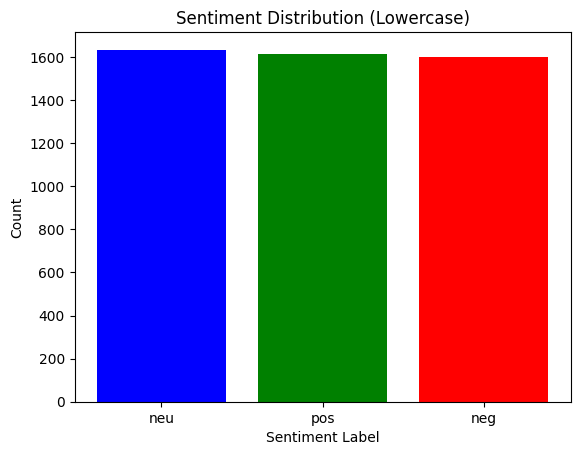

In [ ]:
from collections import Counter

lowercase_data = [(item[0].lower(),) for item in data]

# Extract the sentiment labels from the lowercase data
sentiments = [item[0] for item in lowercase_data]

# Count the occurrences of each sentiment label
sentiment_counts = Counter(sentiments)

# Extract the labels and counts for plotting
labels = list(sentiment_counts.keys())
counts = list(sentiment_counts.values())

# Create a bar graph
plt.bar(labels, counts, color=['blue', 'green', 'red'])
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

In [135]:
texts = combined_data['text']

data = []

# Iterate through each row in the dataset
for text in zip(texts):
    data.append((text))

print(data)
print(len(data))

[('I',), ('Yes',), ('I have a pending claim and the company fixing my car has chosen a date and has said my excess is $1000 according to Tower. My current policy states my excess is $500. \nMy claim number is Claim numberC90154716 Hi, Neetu is looking after my claim\n\n______',), ('Hi there',), ('I hv a question do ur cover for traveller if they caught Covid in overseas',), ('No',), ('Help with my quote',), ('Hi I actually wanted to cancel my policy',), ('Hi Charlie bot, im trying to add my airpoints details to my account but it wont save, details are as per my card',), ('i have an account',), ('airpoints',), ('Yes',), ('Emily Robertson',), ('04.04.82',), ('emilybroad04@gmail.com',), ('Airpoints',), ('Thanks Jackie',), ('Thanks Jackie, have just added a screenshot',), ("My insurance payment was scheduled for yesterday but it didn't come out due to the public holiday, when will this payment come out??",), ("Would this payment usually be impacted by a public holiday? Am I still insured i

In [140]:
search_term = "io"

# Search for the search_term in the dataset
matching_entries = [entry for entry in data if search_term in entry]

if matching_entries:
    print("Found matching entries:", matching_entries)
else:
    print("No matching entries found.")

No matching entries found.


In [161]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

# Define your custom stop words
custom_stopwords = set(["to", "and", "the", ".", ",", "?", "!", "'s", "@", "n't", ":", "’","$","V2uploads","io"])

# Combine NLTK and custom stop words
stop_words = set(stopwords.words('english')).union(custom_stopwords)

# Initialize word frequency dictionary
word_freq = {}

# Tokenize each text and update word frequencies
for text in texts:
    tokens = word_tokenize(text)
    for token in tokens:
        # Check if the token is not in the stop words
        if token.lower() not in stop_words:
            if token in word_freq:
                word_freq[token] += 1
            else:
                word_freq[token] = 1

# Sort word frequencies by frequency
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Print the most common words
num_common_words = 20  # Change this to the number you want
most_common_words = sorted_word_freq[:num_common_words]

for word, freq in most_common_words:
    print(f"{word}: {freq}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


parcel: 764
Yes: 738
please: 604
yes: 602
Hi: 580
order: 492
Live: 492
need: 380
chat: 341
thanks: 330
Something: 328
else: 311
account: 297
advisor: 293
get: 289
Speak: 277
gmail.com: 269
thank: 268
email: 267
number: 264


In [157]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

def wordCloudFunction(df,column,numWords):
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    word_string=str(popular_words_nonstop)
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          max_words=numWords,
                          width=2000,height=2000,
                         ).generate(word_string)
    plt.clf()
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()



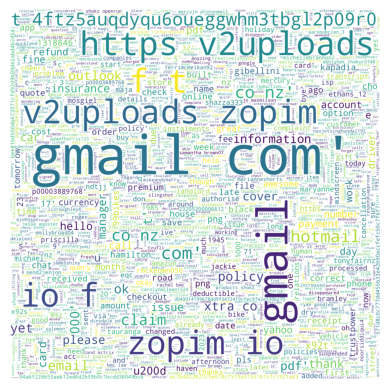

In [158]:
wordCloudFunction(combined_data,"text",10000)

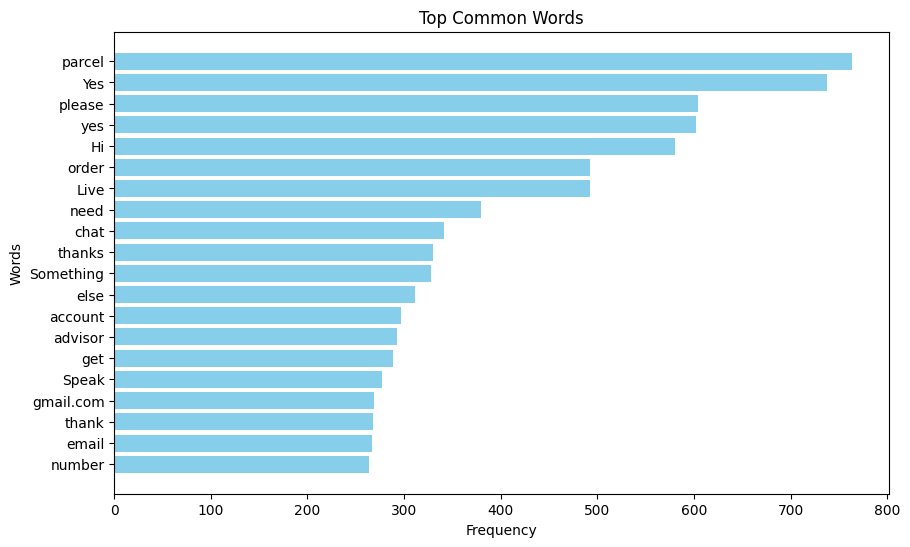

In [162]:
num_common_words = 20  # Change this to the number you want
top_words = [word for word, freq in sorted_word_freq[:num_common_words]]
word_frequencies = [freq for word, freq in sorted_word_freq[:num_common_words]]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words, word_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top Common Words')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common words at the top
plt.show()

In [ ]:
num_common_words = 10  # Change this to the number you want
top_words = [word for word, freq in sorted_word_freq[:num_common_words]]
word_frequencies = [freq for word, freq in sorted_word_freq[:num_common_words]]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_words, word_frequencies, color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top Common Words')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most common words at the top
plt.show()

In [ ]:
# df_filled = pd.concat([df_filled, grouped_df], axis=0, ignore_index=True)
# print(df_filled.head())
# df_filled.to_csv('/content/drive/MyDrive/Tower_Sentiment_New.csv', index=False)

                                                text label
0                                                I I   neu
1                                            Yes Yes   neu
2  I have a pending claim and the company fixing ...   neu
3                                        Hi Hi there   pos
4  I hv a question do Covid ur cover for travelle...   neu


In [ ]:
# import torch
# import random
# import numpy as np
# import pandas as pd
# from torchtext import data

# SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

# # Define the fields
# TEXT = data.Field(
#     tokenize='spacy',
#     tokenizer_language='en_core_web_sm',
#     batch_first=True
# )
# LABEL = data.LabelField(dtype=torch.float)

# # Load your CSV file into a DataFrame (replace with your actual data)
# csv_path = '/content/drive/MyDrive/Tower_Sentiment_New.csv'
# df = pd.read_csv(csv_path)

# # Rename columns if needed
# df = df.rename(columns={'text': 'Text', 'label': 'Sentiment'})

# # Create a torchtext TabularDataset from the pandas DataFrame
# data_fields = [('text', TEXT), ('label', LABEL)]  # Adjust field names as needed
# my_dataset = data.TabularDataset(
#     path=csv_path,  # Path to the directory if needed
#     format='csv',
#     fields=data_fields,
#     skip_header=True,  # Set to False if your CSV has a header
# )

# # Split your dataset into train, validation, and test
# train_data, valid_data, test_data = my_dataset.split(
#     split_ratio=[0.7, 0.15, 0.15],
#     random_state=random.seed(SEED)
# )

# # Build the vocabulary for TEXT field
# MAX_VOCAB_SIZE = 25_000
# TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE, vectors="glove.6B.100d", specials=['<unk>', '<pad>'])

# # Create iterators for train, validation, and test
# BATCH_SIZE = 64
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data, valid_data, test_data),
#     batch_size=BATCH_SIZE,
#     device=device
# )


In [ ]:
# missing_values = df_filled.isna().any().any()  # Returns True if there are missing values

# # Check for missing values in a specific column (e.g., 'column_name')
# missing_values_in_column = df_filled['text'].isna().any()

# print(len(df_filled))
# print(missing_values)
# df_filled.dropna()
# print(len(df_filled))

# print(df_filled.tail())

2095
False
2095
                                                   text label
2090  i cant see my policies. Hmm.. sorry I couldn't...   neu
2091  Hi - can you please have an update on my claim...   neu
2092  Hi, I am currently overseas and need to pay my...   neu
2093  I broke down yesterday n my way to Palmerston ...   neu
2094  Interested party on a vehicle. Hmm.. sorry I c...   neg


In [ ]:
# result = df_filled['label'].str.contains("n")
# filtered_df = df_filled[result]

# print(filtered_df)

                                                   text label
0                                                   I I   neu
1                                               Yes Yes   neu
2     I have a pending claim and the company fixing ...   neu
4     I hv a question do Covid ur cover for travelle...   neu
5                                                 No No   neu
...                                                 ...   ...
2090  i cant see my policies. Hmm.. sorry I couldn't...   neu
2091  Hi - can you please have an update on my claim...   neu
2092  Hi, I am currently overseas and need to pay my...   neu
2093  I broke down yesterday n my way to Palmerston ...   neu
2094  Interested party on a vehicle. Hmm.. sorry I c...   neg

[1388 rows x 2 columns]


In [ ]:
# import torch
# import random
# import numpy as np
# import pandas as pd
# from torchtext import data
# from torchtext import datasets

# SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

# # Define the fields
# TEXT = data.Field(
#     tokenize='spacy',
#     tokenizer_language='en_core_web_sm',
#     batch_first=True
# )
# LABEL = data.LabelField(dtype=torch.float)

# # Load your CSV file into a DataFrame (replace with your actual data)
# csv_path = '/content/drive/MyDrive/new_data.csv'
# df = pd.read_csv(csv_path)

# # Rename columns if needed
# df = df.rename(columns={'text': 'Text', 'label': 'Sentiment'})

# # Create a torchtext TabularDataset from the pandas DataFrame
# data_fields = [('text', TEXT), ('label', LABEL)]  # Adjust field names as needed
# my_dataset = data.TabularDataset(
#     path=csv_path,  # Path to the directory if needed
#     format='csv',
#     fields=data_fields,
#     skip_header=True,  # Set to False if your CSV has a header
# )

# # Split your dataset into train, validation, and test
# train_data1, valid_data1, test_data1 = my_dataset.split(
#     split_ratio=[0.7, 0.15, 0.15],
#     random_state=random.seed(SEED)
# )

# # Build the vocabulary for TEXT field
# MAX_VOCAB_SIZE = 25_000
# TEXT.build_vocab(train_data1, max_size=MAX_VOCAB_SIZE, vectors="glove.6B.100d", specials=['<unk>', '<pad>'])

# # Create iterators for train, validation, and test
# BATCH_SIZE = 64
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data1, valid_data1, test_data1),
#     batch_size=BATCH_SIZE,
#     device=device
# )

# # Optionally, you can load IMDB data as well
# train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
# train_data, valid_data = train_data.split(random_state=random.seed(SEED))

# combined_train_data = train_data + train_data1
# combined_valid_data = valid_data + valid_data1
# combined_test_data = test_data + test_data1


KeyboardInterrupt: ignored

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
from torchtext import data
from torchtext import datasets

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Define the fields
TEXT = data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    batch_first=True
)
LABEL = data.LabelField(dtype=torch.float)

# Load your CSV file into a DataFrame (replace with your actual data)
csv_path = '/content/drive/MyDrive/new_data.csv'
df = pd.read_csv(csv_path)

# Rename columns if needed
df = df.rename(columns={'text': 'Text', 'label': 'Sentiment'})

# Create a torchtext TabularDataset from the pandas DataFrame
data_fields = [('text', TEXT), ('label', LABEL)]  # Adjust field names as needed
my_dataset = data.TabularDataset(
    path=csv_path,  # Path to the directory if needed
    format='csv',
    fields=data_fields,
    skip_header=True,  # Set to False if your CSV has a header
)

# Split your dataset into train, validation, and test
train_data1, valid_data1, test_data1 = my_dataset.split(
    split_ratio=[0.7, 0.15, 0.15],
    random_state=random.seed(SEED)
)

# Build the vocabulary for TEXT field
MAX_VOCAB_SIZE = 25_000
TEXT.build_vocab(train_data1, max_size=MAX_VOCAB_SIZE, vectors="glove.6B.100d", specials=['<unk>', '<pad>'])

# Create iterators for train, validation, and test
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data1, valid_data1, test_data1),
    batch_size=BATCH_SIZE,
    device=device
)

# Optionally, you can load IMDB data as well
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

combined_train_data = train_data
combined_valid_data = valid_data
combined_test_data = test_data


.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [00:19<00:00, 20130.32it/s]


downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 15.6MB/s]


In [ ]:
type(combined_train_data)

torchtext.data.dataset.Dataset

In [ ]:
# import torch
# from torchtext import data
# from torchtext import datasets
# import random
# import numpy as np

# SEED = 1234

# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

# TEXT = data.Field(tokenize = 'spacy',
#                   tokenizer_language = 'en_core_web_sm',
#                   batch_first = True)
# LABEL = data.LabelField(dtype = torch.float)

# train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

# train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Build the vocab and load the pre-trained word embeddings.

In [ ]:
# Print the first few examples from train_data for inspection
for example in train_data[:10]:
    print(vars(example))


NameError: ignored

In [ ]:
for example in train_data[:5]:
    print(example.text)  # Verify that 'text' and 'label' fields exist
    print(example.label)



NameError: ignored

In [ ]:
# Assuming your dataset has a 'text' field
print(len(train_data))
print(len(combined_train_data))



NameError: ignored

In [ ]:
# Extract unique labels from the training data
unique_labels = set([example.label for example in combined_train_data])

# Convert the set of unique labels to a list
label_vocab_list = list(unique_labels)

# Assign the list of labels as the vocabulary for the LABEL field
LABEL.build_vocab(label_vocab_list)


In [ ]:
import collections
from torchtext.vocab import Vocab

MAX_VOCAB_SIZE = 25_000

# Tokenize and collect all words from the training data
all_tokens = []
for example in combined_train_data:
    all_tokens.extend(example.text)

# Count the frequency of each token
token_counter = collections.Counter(all_tokens)

# Create vocabulary for the TEXT field
TEXT.vocab = Vocab(token_counter, max_size=MAX_VOCAB_SIZE, vectors="glove.6B.100d", specials=['<unk>', '<pad>'])

In [ ]:
# MAX_VOCAB_SIZE = 25_000

# # Build vocabulary for the TEXT field using train_data
# TEXT.build_vocab(train_data,
#                  max_size=MAX_VOCAB_SIZE,
#                  vectors="glove.6B.100d",
#                  unk_init=torch.Tensor.normal_)

# # Build vocabulary for the LABEL field using train_data
# LABEL.build_vocab(train_data)


As before, we create the iterators.

In [ ]:
# BATCH_SIZE = 64

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data, valid_data, test_data),
#     batch_size = BATCH_SIZE,
#     device = device)

In [ ]:
# Create iterators for each individual dataset without sorting
# train_iterator1, valid_iterator1, test_iterator1 = data.BucketIterator.splits(
#     (train_data1, valid_data1, test_data1),
#     batch_size=BATCH_SIZE,
#     device=device,
#     sort=False  # Disable sorting
# )

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort=False  # Disable sorting
)

# Concatenate the iterators manually
combined_train_iterator = list(train_iterator)
combined_valid_iterator = list(valid_iterator)
combined_test_iterator = list(test_iterator)

# Iterate through batches in the combined training iterator
for batch in combined_valid_iterator:
    print(batch.text.shape)


print(batch.label.shape)


torch.Size([64, 957])
torch.Size([64, 813])
torch.Size([64, 1009])
torch.Size([64, 2789])
torch.Size([64, 754])
torch.Size([64, 1015])
torch.Size([64, 921])
torch.Size([64, 1080])
torch.Size([64, 1084])
torch.Size([64, 1137])
torch.Size([64, 864])
torch.Size([64, 1049])
torch.Size([64, 926])
torch.Size([64, 878])
torch.Size([64, 946])
torch.Size([64, 1246])
torch.Size([64, 1122])
torch.Size([64, 1191])
torch.Size([64, 892])
torch.Size([64, 1285])
torch.Size([64, 1365])
torch.Size([64, 1019])
torch.Size([64, 843])
torch.Size([64, 1172])
torch.Size([64, 1141])
torch.Size([64, 1039])
torch.Size([64, 750])
torch.Size([64, 1093])
torch.Size([64, 1176])
torch.Size([64, 1160])
torch.Size([64, 680])
torch.Size([64, 1244])
torch.Size([64, 865])
torch.Size([64, 1119])
torch.Size([64, 974])
torch.Size([64, 952])
torch.Size([64, 847])
torch.Size([64, 806])
torch.Size([64, 888])
torch.Size([64, 835])
torch.Size([64, 1115])
torch.Size([64, 1156])
torch.Size([64, 949])
torch.Size([64, 1140])
torch.Si

In [ ]:
# # Create iterators for each individual dataset without sorting
# train_iterator1, valid_iterator1, test_iterator1 = data.BucketIterator.splits(
#     (train_data1, valid_data1, test_data1),
#     batch_size=BATCH_SIZE,
#     device=device,
#     sort=False  # Disable sorting
# )

# train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
#     (train_data, valid_data, test_data),
#     batch_size=BATCH_SIZE,
#     device=device,
#     sort=False  # Disable sorting
# )

# # Concatenate the iterators manually
# combined_train_iterator = list(train_iterator1) + list(train_iterator)
# combined_valid_iterator = list(valid_iterator1) + list(valid_iterator)
# combined_test_iterator = list(test_iterator1) + list(test_iterator)

# # Iterate through batches in the combined training iterator
# for batch in combined_valid_iterator:
#     print(batch.text.shape)


# print(batch.label.shape)


NameError: ignored

## Build the Model

Now to build our model.

The first major hurdle is visualizing how CNNs are used for text. Images are typically 2 dimensional (we'll ignore the fact that there is a third "colour" dimension for now) whereas text is 1 dimensional. However, we know that the first step in almost all of our previous tutorials (and pretty much all NLP pipelines) is converting the words into word embeddings. This is how we can visualize our words in 2 dimensions, each word along one axis and the elements of vectors aross the other dimension. Consider the 2 dimensional representation of the embedded sentence below:

![](assets/sentiment9.png)

We can then use a filter that is **[n x emb_dim]**. This will cover $n$ sequential words entirely, as their width will be `emb_dim` dimensions. Consider the image below, with our word vectors are represented in green. Here we have 4 words with 5 dimensional embeddings, creating a [4x5] "image" tensor. A filter that covers two words at a time (i.e. bi-grams) will be **[2x5]** filter, shown in yellow, and each element of the filter with have a _weight_ associated with it. The output of this filter (shown in red) will be a single real number that is the weighted sum of all elements covered by the filter.

![](assets/sentiment12.png)

The filter then moves "down" the image (or across the sentence) to cover the next bi-gram and another output (weighted sum) is calculated.

![](assets/sentiment13.png)

Finally, the filter moves down again and the final output for this filter is calculated.

![](assets/sentiment14.png)

In our case (and in the general case where the width of the filter equals the width of the "image"), our output will be a vector with number of elements equal to the height of the image (or lenth of the word) minus the height of the filter plus one, $4-2+1=3$ in this case.

This example showed how to calculate the output of one filter. Our model (and pretty much all CNNs) will have lots of these filters. The idea is that each filter will learn a different feature to extract. In the above example, we are hoping each of the **[2 x emb_dim]** filters will be looking for the occurence of different bi-grams.

In our model, we will also have different sizes of filters, heights of 3, 4 and 5, with 100 of each of them. The intuition is that we will be looking for the occurence of different tri-grams, 4-grams and 5-grams that are relevant for analysing sentiment of movie reviews.

The next step in our model is to use *pooling* (specifically *max pooling*) on the output of the convolutional layers. This is similar to the FastText model where we performed the average over each of the word vectors, implemented by the `F.avg_pool2d` function, however instead of taking the average over a dimension, we are taking the maximum value over a dimension. Below an example of taking the maximum value (0.9) from the output of the convolutional layer on the example sentence (not shown is the activation function applied to the output of the convolutions).

![](assets/sentiment15.png)

The idea here is that the maximum value is the "most important" feature for determining the sentiment of the review, which corresponds to the "most important" n-gram within the review. How do we know what the "most important" n-gram is? Luckily, we don't have to! Through backpropagation, the weights of the filters are changed so that whenever certain n-grams that are highly indicative of the sentiment are seen, the output of the filter is a "high" value. This "high" value then passes through the max pooling layer if it is the maximum value in the output.

As our model has 100 filters of 3 different sizes, that means we have 300 different n-grams the model thinks are important. We concatenate these together into a single vector and pass them through a linear layer to predict the sentiment. We can think of the weights of this linear layer as "weighting up the evidence" from each of the 300 n-grams and making a final decision.

### Implementation Details

We implement the convolutional layers with `nn.Conv2d`. The `in_channels` argument is the number of "channels" in your image going into the convolutional layer. In actual images this is usually 3 (one channel for each of the red, blue and green channels), however when using text we only have a single channel, the text itself. The `out_channels` is the number of filters and the `kernel_size` is the size of the filters. Each of our `kernel_size`s is going to be **[n x emb_dim]** where $n$ is the size of the n-grams.

In PyTorch, RNNs want the input with the batch dimension second, whereas CNNs want the batch dimension first - we do not have to permute the data here as we have already set `batch_first = True` in our `TEXT` field. We then pass the sentence through an embedding layer to get our embeddings. The second dimension of the input into a `nn.Conv2d` layer must be the channel dimension. As text technically does not have a channel dimension, we `unsqueeze` our tensor to create one. This matches with our `in_channels=1` in the initialization of our convolutional layers.

We then pass the tensors through the convolutional and pooling layers, using the `ReLU` activation function after the convolutional layers. Another nice feature of the pooling layers is that they handle sentences of different lengths. The size of the output of the convolutional layer is dependent on the size of the input to it, and different batches contain sentences of different lengths. Without the max pooling layer the input to our linear layer would depend on the size of the input sentence (not what we want). One option to rectify this would be to trim/pad all sentences to the same length, however with the max pooling layer we always know the input to the linear layer will be the total number of filters. **Note**: there an exception to this if your sentence(s) are shorter than the largest filter used. You will then have to pad your sentences to the length of the largest filter. In the IMDb data there are no reviews only 5 words long so we don't have to worry about that, but you will if you are using your own data.

Finally, we perform dropout on the concatenated filter outputs and then pass them through a linear layer to make our predictions.

"The quick brown," "quick brown fox," "brown fox jumps,"

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.conv_0 = nn.Conv2d(in_channels = 1,
                                out_channels = n_filters,
                                kernel_size = (filter_sizes[0], embedding_dim))

        self.conv_1 = nn.Conv2d(in_channels = 1,
                                out_channels = n_filters,
                                kernel_size = (filter_sizes[1], embedding_dim))

        self.conv_2 = nn.Conv2d(in_channels = 1,
                                out_channels = n_filters,
                                kernel_size = (filter_sizes[2], embedding_dim))

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]

        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]

        embedded = embedded.unsqueeze(1)

        #embedded = [batch size, 1, sent len, emb dim]

        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

Currently the `CNN` model can only use 3 different sized filters, but we can actually improve the code of our model to make it more generic and take any number of filters.

We do this by placing all of our convolutional layers in a  `nn.ModuleList`, a function used to hold a list of PyTorch `nn.Module`s. If we simply used a standard Python list, the modules within the list cannot be "seen" by any modules outside the list which will cause us some errors.

We can now pass an arbitrary sized list of filter sizes and the list comprehension will create a convolutional layer for each of them. Then, in the `forward` method we iterate through the list applying each convolutional layer to get a list of convolutional outputs, which we also feed through the max pooling in a list comprehension before concatenating together and passing through the dropout and linear layers.

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1,
                                              out_channels = n_filters,
                                              kernel_size = (fs, embedding_dim))
                                    for fs in filter_sizes
                                    ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]

        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]

        embedded = embedded.unsqueeze(1)

        #embedded = [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

We can also implement the above model using 1-dimensional convolutional layers, where the embedding dimension is the "depth" of the filter and the number of tokens in the sentence is the width.

We'll run our tests in this notebook using the 2-dimensional convolutional model, but leave the implementation for the 1-dimensional model below for anyone interested.

In [ ]:
class CNN1d(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = embedding_dim,
                                              out_channels = n_filters,
                                              kernel_size = fs)
                                    for fs in filter_sizes
                                    ])

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text):

        #text = [batch size, sent len]

        embedded = self.embedding(text)

        #embedded = [batch size, sent len, emb dim]

        embedded = embedded.permute(0, 2, 1)

        #embedded = [batch size, emb dim, sent len]

        conved = [F.relu(conv(embedded)) for conv in self.convs]

        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        #pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)

We create an instance of our `CNN` class.

We can change `CNN` to `CNN1d` if we want to run the 1-dimensional convolutional model, noting that both models give almost identical results.

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [1,2]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]




model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

Checking the number of parameters in our model we can see it has about the same as the FastText model.

Both the `CNN` and the `CNN1d` models have the exact same number of parameters.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,590,801 trainable parameters


Next, we'll load the pre-trained embeddings

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.0378, -0.0032,  0.2337,  ..., -0.1429, -0.5320, -0.9142],
        [ 0.0010, -0.1038,  0.4295,  ..., -0.4974, -0.8185,  0.7238],
        [-0.8699,  0.0444, -0.4751,  ...,  0.0196, -0.6144,  0.8288]])

Then zero the initial weights of the unknown and padding tokens.

In [ ]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

Training is the same as before. We initialize the optimizer, loss function (criterion) and place the model and criterion on the GPU (if available)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

We define a function for training our model...

**Note**: as we are using dropout again, we must remember to use `model.train()` to ensure the dropout is "turned on" while training.

In [ ]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        predictions = model(batch.text).squeeze(1)




        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

We define a function for testing our model...

**Note**: again, as we are now using dropout, we must remember to use `model.eval()` to ensure the dropout is "turned off" while evaluating.

In [ ]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            predictions = model(batch.text).squeeze(1)




            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Let's define our function to tell us how long epochs take.

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model...

In [ ]:
for batch in combined_valid_iterator:
    print(batch.text.shape)



torch.Size([64, 957])
torch.Size([64, 813])
torch.Size([64, 1009])
torch.Size([64, 2789])
torch.Size([64, 754])
torch.Size([64, 1015])
torch.Size([64, 921])
torch.Size([64, 1080])
torch.Size([64, 1084])
torch.Size([64, 1137])
torch.Size([64, 864])
torch.Size([64, 1049])
torch.Size([64, 926])
torch.Size([64, 878])
torch.Size([64, 946])
torch.Size([64, 1246])
torch.Size([64, 1122])
torch.Size([64, 1191])
torch.Size([64, 892])
torch.Size([64, 1285])
torch.Size([64, 1365])
torch.Size([64, 1019])
torch.Size([64, 843])
torch.Size([64, 1172])
torch.Size([64, 1141])
torch.Size([64, 1039])
torch.Size([64, 750])
torch.Size([64, 1093])
torch.Size([64, 1176])
torch.Size([64, 1160])
torch.Size([64, 680])
torch.Size([64, 1244])
torch.Size([64, 865])
torch.Size([64, 1119])
torch.Size([64, 974])
torch.Size([64, 952])
torch.Size([64, 847])
torch.Size([64, 806])
torch.Size([64, 888])
torch.Size([64, 835])
torch.Size([64, 1115])
torch.Size([64, 1156])
torch.Size([64, 949])
torch.Size([64, 1140])
torch.Si

In [ ]:
# import torch.optim as optim

# # Define your model, loss function, and other settings here

# # Define an initial learning rate
# initial_lr = 0.001  # You can adjust this value

# # Create an optimizer and set the initial learning rate
# optimizer = optim.Adam(model.parameters(), lr=initial_lr)


# N_EPOCHS = 5

# best_valid_loss = float('inf')

# # Inside your training loop
# for epoch in range(N_EPOCHS):
#     # Calculate loss and perform backpropagation

#     # Optionally, adjust the learning rate during training (e.g., every epoch)
#     # You can use a learning rate scheduler or manually change the lr value
#     new_lr = adjust_learning_rate(initial_lr, epoch)  # Define this function

#     for param_group in optimizer.param_groups:
#         param_group['lr'] = new_lr

#         start_time = time.time()

#         train_loss, train_acc = train(model, combined_train_iterator, optimizer, criterion)
#         valid_loss, valid_acc = evaluate(model, combined_valid_iterator, criterion)

#         end_time = time.time()

#         epoch_mins, epoch_secs = epoch_time(start_time, end_time)

#         if valid_loss < best_valid_loss:
#             best_valid_loss = valid_loss
#             torch.save(model.state_dict(), 'tut4-model.pt')

#         print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
#         print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#         print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:


N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, combined_train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, combined_valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 15m 43s
	Train Loss: 0.506 | Train Acc: 74.29%
	 Val. Loss: 0.355 |  Val. Acc: 84.75%
Epoch: 02 | Epoch Time: 15m 20s
	Train Loss: 0.316 | Train Acc: 86.37%
	 Val. Loss: 0.297 |  Val. Acc: 87.78%
Epoch: 03 | Epoch Time: 15m 21s
	Train Loss: 0.232 | Train Acc: 90.81%
	 Val. Loss: 0.277 |  Val. Acc: 88.67%
Epoch: 04 | Epoch Time: 15m 25s
	Train Loss: 0.164 | Train Acc: 94.00%
	 Val. Loss: 0.282 |  Val. Acc: 88.46%
Epoch: 05 | Epoch Time: 15m 17s
	Train Loss: 0.107 | Train Acc: 96.24%
	 Val. Loss: 0.288 |  Val. Acc: 88.87%


We get test results comparable to the previous 2 models!

In [ ]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss, test_acc = evaluate(model, combined_test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.276 | Test Acc: 88.55%


## User Input

And again, as a sanity check we can check some input sentences

**Note**: As mentioned in the implementation details, the input sentence has to be at least as long as the largest filter height used. We modify our `predict_sentiment` function to also accept a minimum length argument. If the tokenized input sentence is less than `min_len` tokens, we append padding tokens (`<pad>`) to make it `min_len` tokens.

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = torch.sigmoid(model(tensor))
    return prediction.item()

An example negative review...

In [ ]:
predict_sentiment(model, "perfect")

0.9217289090156555

An example positive review...

In [ ]:
predict_sentiment(model, "bad")

0.1952885538339615

In [ ]:
predict_sentiment(model, "good but bad")

0.2356150895357132

In [ ]:
texts =   combined_data['text']
sentiments = combined_data['label']

data = []

# Iterate through each row in the dataset
for text, sentiment in zip(texts, sentiments):
    data.append((text, sentiment))

In [ ]:
print(data)

[('I I', 'neu'), ('Yes Yes', 'neu'), ('I have a pending claim and the company fixing my car has chosen a date and has said my excess is $1000 according to Tower. My current policy and states my excess is $500. \nMy claim number is Claim numberC90154716 Hi, Neetu is looking after my claim\n\n______', 'neu'), ('Hi Hi there', 'pos'), ('I hv a question do ur cover for traveller if they caught Covid caught in overseas', 'neu'), ('No No', 'neu'), ('Help with with my quote', 'neu'), ('Hi I actually wanted to cancel my policy actually', 'pos'), ('Hi Charlie per bot, im trying to add my airpoints details to my account but it wont save, details are as per my card', 'pos'), ('i account have an account', 'neu'), ('airpoints airpoints', 'neu'), ('Yes Yes', 'pos'), ('Emily Robertson Robertson', 'neu'), ('04.04.82 04.04.82', 'neu'), ('emilybroad04@gmail.com emilybroad04@gmail.com', 'neu'), ('Airpoints Airpoints', 'neu'), ('Thanks Thanks Jackie', 'pos'), ('Thanks Jackie, have just added have a screens

In [ ]:
sentimentArray = []
score = []
length = len(combined_data)
for i in range (length):
    data = combined_data['text'][i]
    output = predict_sentiment(model, data)

    if output < 0.35:
      sentiment = "neg"
      sentimentArray.append(sentiment)
      score.append(output)
    elif output > 0.35 or output < 0.75:
      sentiment = "neu"
      sentimentArray.append(sentiment)
      score.append(output)

    elif output > 0.75:
      sentiment = "pos"
      sentimentArray.append(sentiment)
      score.append(output)


print(sentimentArray)
print(score)

print(len(sentimentArray))


['neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neg', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu', 'neu'

In [ ]:
# Assuming combined_data["label"] is a list of strings
combined_data_label = combined_data["label"]

# Convert each element to lowercase using a list comprehension
combined_data_label_lower = [label.lower() for label in combined_data_label]

# Now, combined_data_label_lower contains all elements in lowercase


In [ ]:
combined_data_label = combined_data["label"]
sentimentArray # Replace this with your actual sentimentarray
final = []
# Using a loop to compare each element
for i in range(len(combined_data_label)):
    if combined_data_label[i] == sentimentArray[i]:
        # print(f"Element {i}: Matched - combined_data_label: {combined_data_label[i]}, sentimentarray: {sentimentArray[i]}")
        final.append(1)
    else:
        # print(f"Element {i}: Not Matched - combined_data_label: {combined_data_label[i]}, sentimentarray: {sentimentArray[i]}")
        final.append(0)

# Using list comprehension to create a list of comparisons
# comparisons = [combined_data_label[i] == sentimentArray[i] for i in range(len(combined_data_label))]

# Now, 'comparisons' will contain True for matching elements and False for non-matching elements
# print(comparisons)

In [ ]:
count = 0
for i in range (len(final)):
  t = final[i]
  if t == 1:
    count += 1

print(count)
accuracy = (count / len(final)) * 100
print(accuracy)

761
15.454914703493095
